<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/graph-based-topology/undirected_unweighted_drone_direction_consensus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 35.5 MB/s eta 0:00:00


/tmp/ipython-input-37-2085650485.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


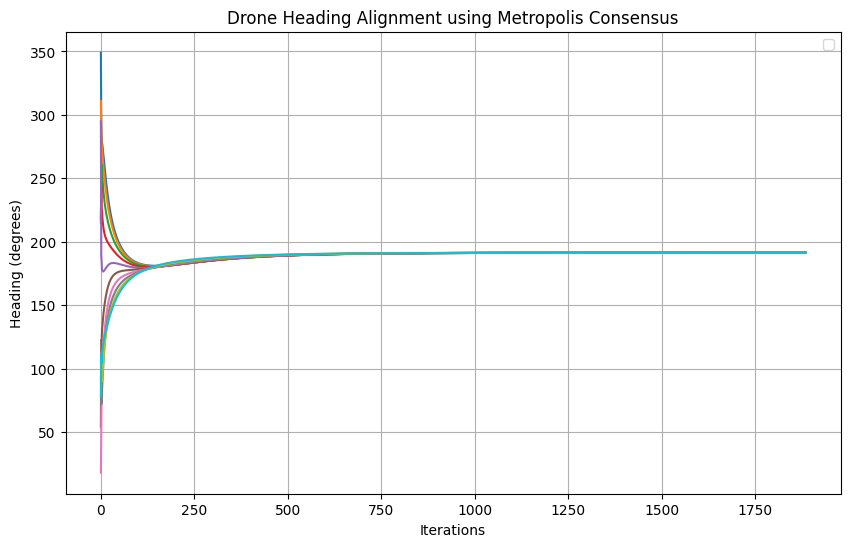

[191.35856424 191.35853618 191.35853121 191.3585494  191.35859046
 191.35865376 191.35873829 191.35884271 191.35896539 191.35910438
 191.3592575  191.35942233 191.35959626 191.35977657 191.35996039
 191.36014485 191.36032702 191.36050403 191.36067309 191.36083154
 191.36097687 191.3611068  191.36121927 191.36131251 191.36138506
 191.36143576 191.36146382 191.36146879 191.3614506  191.36140954
 191.36134624 191.36126171 191.36115729 191.36103461 191.36089562
 191.3607425  191.36057767 191.36040374 191.36022343 191.36003961
 191.35985515 191.35967298 191.35949597 191.35932691 191.35916846
 191.35902313 191.3588932  191.35878073 191.35868749 191.35861494]


In [ ]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt

# Create a connected swarm graph
N = 50
g = ig.Graph.Ring(N)  # ring topology
g.vs["label"] = list(range(N))

# Initial headings in degrees (e.g., 0 to 360) randomly generated based on N
x = np.array(np.random.randint(0, 360, N), dtype=np.float64)
A = np.zeros((N, N))

for i in range(N):
    neighbors = g.neighbors(i)
    deg_i = len(neighbors)
    for j in neighbors:
        deg_j = len(g.neighbors(j))
        A[i, j] = 1 / (1 + max(deg_i, deg_j))
    A[i, i] = 1 - np.sum(A[i])

def run_consensus(x0, A, iterations=100):
  convergence = False
  iters = 0
  xs = [x0.copy()]
  x = x0.copy()

  while not convergence and iters < 5000:
    iters += 1
    x = A @ x
    xs.append(x.copy())
    tol = x[0]
    convergence = np.all([np.isclose(i,tol, atol=1e-3) for i in x])

  return np.array(xs)

xs = run_consensus(x, A, 100)

plt.figure(figsize=(10, 6))

for i in range(10):
    plt.plot(xs[:, i])

plt.title("Drone Heading Alignment using Metropolis Consensus")
plt.xlabel("Iterations")
# add legend for total iterations
plt.legend(f"Convergence iterations : {str(len(xs))}")
plt.ylabel("Heading (degrees)")
plt.legend()
plt.grid(True)
plt.show()

print (xs[-1])


In [38]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt

# Step 1: Create undirected connected graph
n = 10
g = ig.Graph.Erdos_Renyi(n=n, m=15)  # dense enough to ensure connectivity

# Step 2: Metropolis Weights
A = np.zeros((n, n))
for i in range(n):
    for j in g.neighbors(i):
        A[i, j] = 1 / (1 + max(g.degree(i), g.degree(j)))
    A[i, i] = 1 - np.sum(A[i])  # make row-stochastic

# Step 3: Initial headings
x = np.random.uniform(-np.pi, np.pi, size=n)
history = [x.copy()]

# Step 4: Consensus + Turn Left
epsilon = 1e-2
delta = -0.01  # left turn in radians
consensus_achieved = False
max_iters = 200

for t in range(max_iters):
    x_new = A @ x
    if not consensus_achieved:
        if np.max(np.abs(x_new - x)) < epsilon:
            consensus_achieved = True
    else:
        x_new += delta  # apply left turn
    x = x_new
    history.append(x.copy())


Converged after 322 iterations


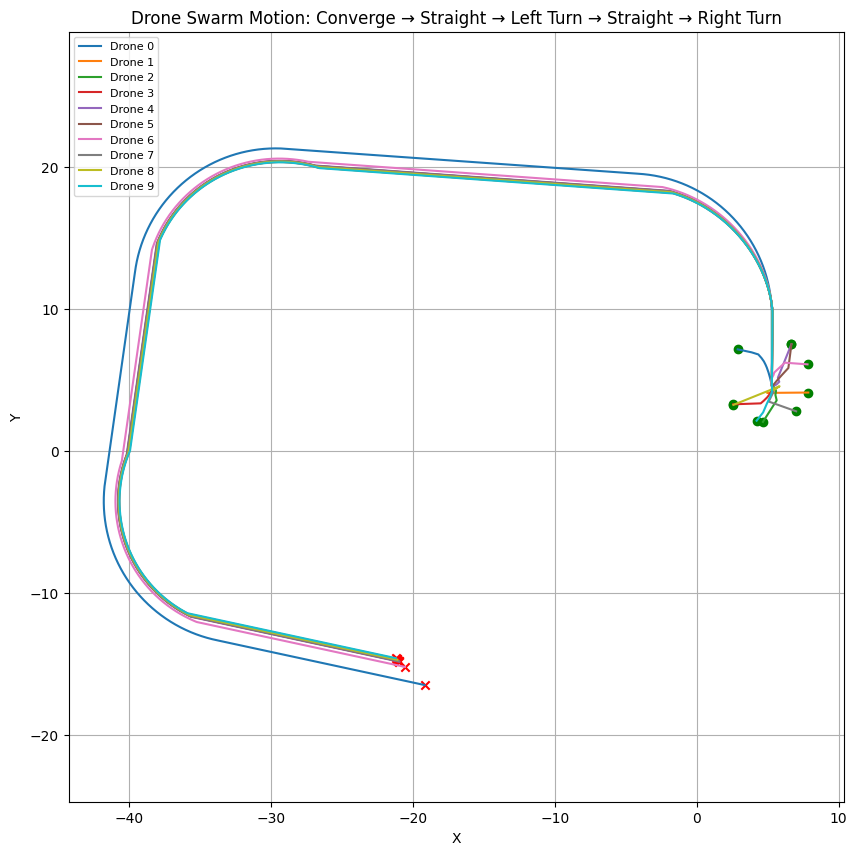

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig

np.random.seed(42)

# Parameters
n = 10
step_size = 0.05
dt = 0.1
north = np.pi / 2
pos_tol = 0.01
heading_tol = 0.01
max_iters = 1000

# Metropolis weights helper
def create_metropolis_weights(g):
    n = g.vcount()
    A = np.zeros((n, n))
    for i in range(n):
        for j in g.neighbors(i):
            A[i, j] = 1 / (1 + max(g.degree(i), g.degree(j)))
        A[i, i] = 1 - np.sum(A[i])
    return A

# Initialization
g = ig.Graph.Erdos_Renyi(n=n, m=15)
A = create_metropolis_weights(g)

angles = np.random.uniform(0, 2*np.pi, size=n)
positions = np.stack([5 + 3 * np.cos(angles), 5 + 3 * np.sin(angles)], axis=1)
headings = np.random.uniform(-np.pi, np.pi, size=n)

trajectories = [positions.copy()]
headings_hist = [headings.copy()]

# Helper functions
def max_pairwise_dist(pos):
    return np.max([np.linalg.norm(pos[i] - pos[j]) for i in range(n) for j in range(i+1, n)])

def angular_diff(a, b):
    return np.arctan2(np.sin(a - b), np.cos(a - b))

# Phase 1: Converge positions and headings
def converge_positions_headings(positions, headings, A, north, pos_tol, heading_tol, max_iters,
                               trajectories, headings_hist):
    for _ in range(max_iters):
        new_headings = A @ headings
        new_headings[0] = north  # Drone 0 knows North

        new_positions = A @ positions

        headings = new_headings
        positions = new_positions

        headings_hist.append(headings.copy())
        trajectories.append(positions.copy())

        pos_converged = max_pairwise_dist(positions) < pos_tol
        heading_converged = np.max(np.abs(angular_diff(headings, headings[0]))) < heading_tol
        if pos_converged and heading_converged:
            print(f"Converged after {_} iterations")
            break
    return positions, headings

# Move straight
def go_straight(positions, headings, ticks, step_size, trajectories, headings_hist):
    for _ in range(ticks):
        delta = step_size * np.stack([np.cos(headings), np.sin(headings)], axis=1)
        positions += delta
        trajectories.append(positions.copy())
        headings_hist.append(headings.copy())
    return positions, headings

# Turn left
def turn_left(positions, headings, ticks, step_size, delta_theta, A, trajectories, headings_hist):
    for _ in range(ticks):
        headings -= delta_theta
        # Drone 0 turns actively and moves
        delta_0 = step_size * np.array([np.cos(headings[0]), np.sin(headings[0])])
        positions[0] += delta_0
        # Other drones update positions by consensus (exclude drone 0)
        positions[1:] = (A @ positions)[1:]
        # All drones move forward along their headings
        delta = step_size * np.stack([np.cos(headings), np.sin(headings)], axis=1)
        positions += delta

        # Update headings consensus with drone 0's updated heading
        new_headings = A @ headings
        new_headings[0] = headings[0]
        headings = new_headings

        trajectories.append(positions.copy())
        headings_hist.append(headings.copy())
    return positions, headings

# Turn right
def turn_right(positions, headings, ticks, step_size, delta_theta, A, trajectories, headings_hist):
    for _ in range(ticks):
        headings += delta_theta  # opposite direction from left
        # Drone 0 turns actively and moves
        delta_0 = step_size * np.array([np.cos(headings[0]), np.sin(headings[0])])
        positions[0] += delta_0
        # Other drones update positions by consensus (exclude drone 0)
        positions[1:] = (A @ positions)[1:]
        # All drones move forward along their headings
        delta = step_size * np.stack([np.cos(headings), np.sin(headings)], axis=1)
        positions += delta

        # Update headings consensus with drone 0's updated heading
        new_headings = A @ headings
        new_headings[0] = headings[0]
        headings = new_headings

        trajectories.append(positions.copy())
        headings_hist.append(headings.copy())
    return positions, headings

# 1) Converge swarm
positions, headings = converge_positions_headings(
    positions, headings, A, north, pos_tol, heading_tol, max_iters, trajectories, headings_hist)

positions, headings = go_straight(
    positions, headings, 100, step_size, trajectories, headings_hist)

positions, headings = turn_left(
    positions, headings, 150, step_size, delta_turn := -0.01, A=A,
    trajectories=trajectories, headings_hist=headings_hist)

positions, headings = go_straight(
    positions, headings, 500, step_size, trajectories, headings_hist)

positions, headings = turn_left(
    positions, headings, 150, step_size, delta_turn := -0.01, A=A,
    trajectories=trajectories, headings_hist=headings_hist)

positions, headings = go_straight(
    positions, headings, 300, step_size, trajectories, headings_hist)

positions, headings = turn_left(
    positions, headings, 150, step_size, delta_turn := -0.01, A=A,
    trajectories=trajectories, headings_hist=headings_hist)

positions, headings = go_straight(
    positions, headings, 300, step_size, trajectories, headings_hist)

# =================
# === PLOT PATH ===
# =================

trajectories = np.array(trajectories)

plt.figure(figsize=(10, 10))
for i in range(n):
    plt.plot(trajectories[:, i, 0], trajectories[:, i, 1], label=f"Drone {i}")
    plt.scatter(trajectories[0, i, 0], trajectories[0, i, 1], c='green', marker='o')  # Start
    plt.scatter(trajectories[-1, i, 0], trajectories[-1, i, 1], c='red', marker='x')  # End

plt.title("Drone Swarm Motion: Converge → Straight → Left Turn → Straight → Right Turn")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.grid(True)
plt.legend(loc='upper left', fontsize=8)
plt.show()
